# Programming for Data Analysis Project
For this project I will be synthesizing a dataset, to do so I will be using various functions of the numpy.random package to create interpretations of real world phenomenon.

An example to illustrate this (as provided by the lecturer), is to consider students enrolled in a module, based on this example it seems sensible to consider each student has a grade at the end of a module and as we know from the common misconception that lecturers grade to a bell curve, is in fact due to the how phenomenon such as this tends to follow a normal distribution.
Following on from this we can assert that there are other factors that will help to determine their grade, such as their level of education going into this module (it stands to reason that someone with a PhD will in general outperform someone who has a bachelors degree), the amount of hours a student studies is also probably effecting their grade as is perhaps whether the student is full time or part time.  

Because I lack creativity I am going to start with this example and work through it in the hopes it gives me some experience in synthesizing data and maybe sparks my own idea in the process.

Additionally at this point I don't want to devote too much time to research the data in question, instead I want to play around with how to generate the data, so I will be making some assumptions which I will call out in comments or markdown text as appropriate.

In [7]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(1)

qualification = ['PhD', 'Masters', 'Bachelors', 'None'] #categories for the various students
qualification_prob = [0.2, 0.3, 0.4, 0.1] #I assume probabilities for these are that secondary is least likely and Bachelors most
grades = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'F'] #setting up a list to determine possible grades

num_students = 200

qual_array = rng.choice(a=qualification, p=qualification_prob, size = 200) #picking from the list of qualifications using the previously defined probabilities
df = pd.DataFrame(columns=['Qualification'], data=qual_array) #using the nunmpy array tocreate the first column for the data table

In [8]:
Hours = rng.normal(loc=4, scale=2,size=200) #taking what Brian said in project pdf, hours per week students are typically centered aroudn a mean of 4 with standard deviation of a quarter and normal distribution is acceptable here
df['Hours per week study'] = Hours #Now I have two columns in my dataframe, qualification and hours per week study
df.head()

,Qualification,Hours per week study
0,Bachelors,6.219276
1,None,4.336212
2,PhD,5.096811
3,None,1.869751
4,Masters,7.656860


## My Simulated Data Idea - An Adults Gender, Height, Weight and Age

My idea here is to simulate a dataset for adults based on their Gender, Height, Weight and age.

- Gender is an easy one to start with as the population can be reasonably divided into half female and half male.

- Age is another easy factor to consider as it is going to be independent of gender, height and weight as none of these will influence someones age.

- Height will be exclusively influenced by their gender.

- Finally weight will be influenced by all of the other factors, as someones gender, height and age will all factor into their weight.

### Exploring the variables in more detail

On the face of it gender appears to be an easy 50 50 chance but for the sake of accuracy and to check the veracity of that claim I took a look at the Central Statistics Office (CSO) Census data for Men and Women, handily the CSO page also includes information for their ages as well.
[Link to CSO page on Men and Women](https://www.cso.ie/en/releasesandpublications/ep/p-cp3oy/cp3/assr/)

Based on the most recent census data (from 2016) the ratio of men to women is not quite equal, there is a minor difference between the ratio of men to women between the ages 15-64 of 980 men to 1000 women. More interestingly however the ratio of men to women broadens significantly when looking at the 65+ age group with 871 men to 1000 women.
To start with I will just work with the 15-64 age group.

In [40]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(1)
#Ratio of men to women for 2016 980 men to 1000 women
p_male_15to64 = round(980/1980, 3) #get the probabilty of being male given age is between 15-64, round to 3 decimal places
p_female_15to64 = 1-p_male_15to64
print('Probability an adult between 15 to 64 years of age is male:',p_male_15to64)
print('Probability an adult between 15 to 64 years of age is female:',p_female_15to64)

Probability an adult between 15 to 64 years of age is male: 0.495
Probability an adult between 15 to 64 years of age is female: 0.505


In [79]:
df = pd.DataFrame(data=rng.choice(['Female','Male'], size=500, p=[p_female_15to64,p_male_15to64]), columns=['Gender'])

### Female and Male heights
This was somewhat tricky to find, which was surprising and I could not find any figures specific to Ireland so instead I am using the information available from https://ourworldindata.org/human-height

The above linked page gives several useful pieces of information for determining height
- Height is normally distributed
- Females have an average height of 164.7cm
    - Std. Deviation of 7.07cm
- Males have an average height of 178.4cm
    - Std. Deviation of 7.59cm

With the above information I can now start simulating data for adult Female and Male heights, however I would like to point out the few generalisations made at this point. The average height and std. deviations listed above are not necessarily the case for Ireland, in fact they probably aren't totally accurate, however in the absence of any truly accurate figures for Ireland these will make a sufficient approximation.
Additionally the data presented from the link above uses a relatively young group of adults, which may further skew how the average height and std. deviation would be in reality as potentially for adults born in the 1970's their average height could be shorter than adults born in 

In [80]:
#df.loc[df['Gender'] =='Male', 'Height'] = rng.normal(loc=178.4,scale=7.07, size=10)
for index, row in df.iterrows():
    if(row['Gender'] == 'Female'):
        df.at[index,'Height (cm)'] = np.round(rng.normal(loc=164.7,scale=7.59, size=1),2)
    elif(row['Gender'] == 'Male'):
        df.at[index,'Height (cm)']  = np.round(rng.normal(loc=178.4,scale=7.07, size=1),2)

In [81]:
df.describe()

,Height (cm)
count,500.00000
mean,172.11976
std,9.51167
min,149.35000
25%,165.33000
50%,172.50500
75%,178.68000
max,202.47000


In [82]:
print(df)

     Gender  Height (cm)
0      Male       171.91
1      Male       178.17
2      Male       175.19
3    Female       162.75
4    Female       155.97
..      ...          ...
495    Male       178.46
496    Male       169.31
497    Male       177.78
498    Male       179.13
499    Male       186.32

[500 rows x 2 columns]


From the CSO website https://www.cso.ie/en/releasesandpublications/ep/p-wamii/womenandmeninireland2016/health/#d.en.142587 I was able see what the percentage of adult Females and Males are that are overweight, unfortunately I wasn't able to find a reliable figure for average weight or standard deviation, or how weight is generally distributed across the population.

Males overweight - 63.1%

Females overweight - 48.4%

Knowing the percentage of women and men that are overweight I am going to use this to information to determine for a given individual whether or not they are overweight.

Once it is determined whether or not they are overweight or a healthy weight (ignoring here the possibility of being severely underweight) I will estimate a value for the weight they are taking into account their height as the criteria for someone being overweight is proportional to their height (e.g. for two different individuals at the same weight one may be overweight and the other not if their weight differs significantly).

Whether someone is overweight or not is determined by their BMI and from the CSO page linked above, they cite a BMI between 25 and 30 as being pre-obese and anything greater than 30 as obese.
BMI is calculated using the formula:
\begin{align}
\ BMI & = \frac{m}{h^{2}} \\
\end{align}

Where m is mass (or Weight) in kg and h is height in cm.

In [83]:
for index, row in df.iterrows(): #loop through each row in dataframe
    if(row['Gender'] == 'Female'): #if row is gender then there is a 48.4% chance they are over weight
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.516,.484])
        if(df.at[index,'Weight Category'] =='Over Weight'): #depending on whether this person was over or healthy weight
            bmi_lower = 25
            bmi_upper = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi_upper = 25
            bmi_lower = 18.5
    elif(row['Gender'] == 'Male'):
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.369,.631])
        if(df.at[index,'Weight Category'] =='Over Weight'):
            bmi_lower = 25
            bmi_upper = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi_upper = 25
            bmi_lower = 18.5
    bmi = rng.integers(bmi_lower,bmi_upper)
    height = df.at[index,'Height (cm)']/100
    weight = bmi*(height**2)
    df.at[index, 'Weight (KG)'] = np.round(weight, 3)

In [84]:
rng.uniform(1,10)

3.1445739535045694

In [85]:
df

,Gender,Height (cm),Weight Category,Weight (KG)
0,Male,171.91,Over Weight,85.704
1,Male,178.17,Over Weight,104.757
2,Male,175.19,Over Weight,76.729
3,Female,162.75,Healthy Weight,58.273
4,Female,155.97,Healthy Weight,46.221
...,...,...,...,...
495,Male,178.46,Over Weight,98.729
496,Male,169.31,Over Weight,80.264
497,Male,177.78,Healthy Weight,56.890
498,Male,179.13,Healthy Weight,60.966


c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


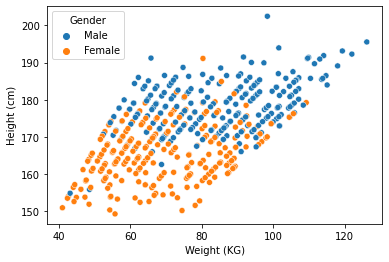

In [86]:
import seaborn as sns
sns.scatterplot( df['Weight (KG)'], df['Height (cm)'], hue=df['Gender']);